<a href="https://colab.research.google.com/github/ludawg44/jigsawlabs/blob/master/21Apr20_Feature%20Engineering%20DateTimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering DateTimes 

### Introduction

Imagine that we are trying to predict the amount of purchases of Diet Dr. Pepper in a grocery store.  We have a dataset of past purchase information.

If one of our features in our dataset is a datetime, we have a lot of information to unpack.  

For example:

* What day of the week was the purchase?  
* Was it near a payday, a holiday?  
* Is it in the winter or summer?  

In this lesson, we'll look at the various features we can generate from a datetime column, a way of organizing our thinking about these features, and some tools for working with this feature.

### Domain

In this lesson, we'll work with the [Chicago Crimes Dataset](https://www.kaggle.com/currie32/crimes-in-chicago).  Now, to make our dataset more manageable, we already limited our dataset down to minor marijuana possessions and stored this data in a separate csv file called `chicago_poss.csv`.

```python
import pandas as pd
df = pd.read_csv('chicago_crimes.csv')
weed_df = df[df.description == 'POSS: CANNABIS 30GMS OR LESS']
selected_columns = ['date']
selected_df = df[selected_columns]
```

Let's load up the `chicago_poss.csv` file.

In [0]:
import pandas as pd
url = "https://raw.githubusercontent.com/jigsawlabs-student/feature-engineering/master/5-datetimes/chicago_poss.csv"
df = pd.read_csv(url, index_col = 0)

In [0]:
df[:2]

,unnamed:_0,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
140,32450,10509515,HZ251054,05/04/2016 12:50:00 PM,004XX W 97TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,...,21.0,73.0,18,1174958.0,1840580.0,2016,05/11/2016 03:50:55 PM,41.717933,-87.634796,"(41.717933377, -87.634796373)"
181,44256,10508668,HZ250525,05/04/2016 12:15:00 AM,033XX W FLOURNOY ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,SIDEWALK,True,...,24.0,27.0,18,1154249.0,1896836.0,2016,05/11/2016 03:50:55 PM,41.872744,-87.709150,"(41.87274397, -87.709149899)"


Let's begin by selecting our `date` column and converting it into a datetime.

In [0]:
date_col = pd.to_datetime(df.date)

In [0]:
df = df.assign(date_and_time = date_col)

Ok, now let's begin to explore the different kinds of information we can extract from a date.  Let's select our first date, and get started.

In [0]:
first_day = df['date_and_time'].iloc[0]

In [0]:
first_day.day_name()

'Wednesday'

In [0]:
first_day.date()

datetime.date(2016, 5, 4)

## Moving to our regression problem

Ok, now let's try to use this date information as a regression problem.  Let's take another look at our data.

Imagine that we want to predict the number of marijuana possessions that will be recorded on a given day.  To do so, we'll need data that looks like the following:

| day  | count  |
|---|---|
| 10/3/12  | 73  |
| 5/4/16  | 50  |
| 8/10/17  |  65 |


Currently, we don't have our data aggregated by day, but rather each possession record listed individually, with the related date and time.  

In [0]:
df[['description', 'date_and_time']][:3]

,description,date_and_time
140,POSS: CANNABIS 30GMS OR LESS,2016-05-04 12:50:00
181,POSS: CANNABIS 30GMS OR LESS,2016-05-04 00:15:00
182,POSS: CANNABIS 30GMS OR LESS,2016-05-04 00:14:00


So let's change this.  To do aggregate we first need to create a new column **just of the dates** from our date and time.

In [0]:
df['date'] = df.date_and_time.map(lambda x: x.date())

In [0]:
df['date'][0:3]

140    2016-05-04
181    2016-05-04
182    2016-05-04
Name: date, dtype: object

And now we can group all of our rows by the date, and count up the number of rows for each date.

In [0]:
df_aggregated = df.groupby('date').count()


In [0]:
df_aggregated[0:2]

,unnamed:_0,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,...,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,date_col,only_date,date_and_time
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
2012-01-02,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48


In [0]:
poss_dates_and_counts = df_aggregated.iloc[:, :1]

In [0]:
poss_dates_and_counts.columns = ['count']

In [0]:
poss_dates_and_counts[:2]

,count
date,
2012-01-01,42
2012-01-02,48


Ok, great, so now we'd like build a regression model where we use the date to predict the number of crimes reported for that day. 

### Periodic Features from Dates

It may seem ambitious to try to predict the number of crimes just from the date, but remember, there are many features that we  can derive from dates.

Features like:

* day number in the week
* day of month
* month
* season
* day of year

And if we also had included the time component, we could add hour, minute and second to that.  

The team at `fast.ai` put together an excellent library for extracting these features and a lot more.  

> We'll copy the code here for you to examine.

In [0]:
import numpy as np
import re
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

Ok, to use the library, we can first create a new column simply of the date.

In [0]:
poss_dates_and_counts[:2]

,count
date,
2012-01-01,42
2012-01-02,48


In [0]:
poss_dates_and_counts = poss_dates_and_counts.assign(date = poss_dates_and_counts.index)

In [0]:
poss_dates_and_counts[:2]

,count,date
date,,
2012-01-01,42,2012-01-01
2012-01-02,48,2012-01-02


Then we can call the `add_datepart` method on our `date` column.

In [0]:
add_datepart(poss_dates_and_counts, 'date')

In [0]:
poss_dates_and_counts[:3]

,count,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
date,,,,,,,,,,,,,,
2012-01-01,42,2012,1,52,1,6,1,False,True,False,True,False,True,1325376000
2012-01-02,48,2012,1,1,2,0,2,False,False,False,False,False,False,1325462400
2012-01-03,36,2012,1,1,3,1,3,False,False,False,False,False,False,1325548800


This does a pretty good job, but it treats the day of the week as a number.  For the purposes of linear regression it's better to treat this as a category.

In [0]:
days_of_week_df = pd.get_dummies(poss_dates_and_counts.Dayofweek, drop_first=True)
days_of_week_df.columns = ['Sun', 'Mon', 'Tues', 'Weds', 'Thurs', 'Fri']

In [0]:
# df_aggregated.drop(columns = ['Dayofweek'])
agg_cats_df = pd.concat([poss_dates_and_counts, days_of_week_df], axis=1)

In [0]:
agg_cats_df[:2]

,count,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Sun,Mon,Tues,Weds,Thurs,Fri
date,,,,,,,,,,,,,,,,,,,,
2012-01-01,42,2012,1,52,1,6,1,False,True,False,True,False,True,1325376000,0,0,0,0,0,1
2012-01-02,48,2012,1,1,2,0,2,False,False,False,False,False,False,1325462400,0,0,0,0,0,0


### Train the model

In [0]:
X = agg_cats_df.iloc[:, 1:]
y = agg_cats_df.iloc[:, 0]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

model.coef_

array([-7.87671317e+02,  1.05811639e+02,  1.06570234e-01,  3.41760750e+00,
       -7.28675304e-02, -5.66907773e+00, -5.34163922e-01,  1.35209237e+00,
        7.16023695e-01,  1.99339430e+00, -1.27017929e+01, -2.25815727e+01,
        2.46696248e-05,  4.45798373e-01,  1.73351869e+00,  8.42578293e-01,
        2.82531493e+00, -1.18563401e+00, -1.98108797e+00])

In [0]:
model.score(X_train, y_train)

0.7463042533867803

In [0]:
model.score(X_test, y_test)

0.749749735207782

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# make predictions on all of them 
test_predictions = model.predict(X_test)
sqrt(mean_squared_error(y_test, test_predictions))

8.509964996220509

The $RMSE$ is 8.5, which looks pretty good considering the dataset.  And the coefficient of determination is .75, which means that our model does a good bit better than just predicting the mean count of possession records.

Let's plot our model alongside the dates to see how we did.

In [0]:
predictions = model.predict(X_train)

In [0]:
y_train.shape

(1372,)

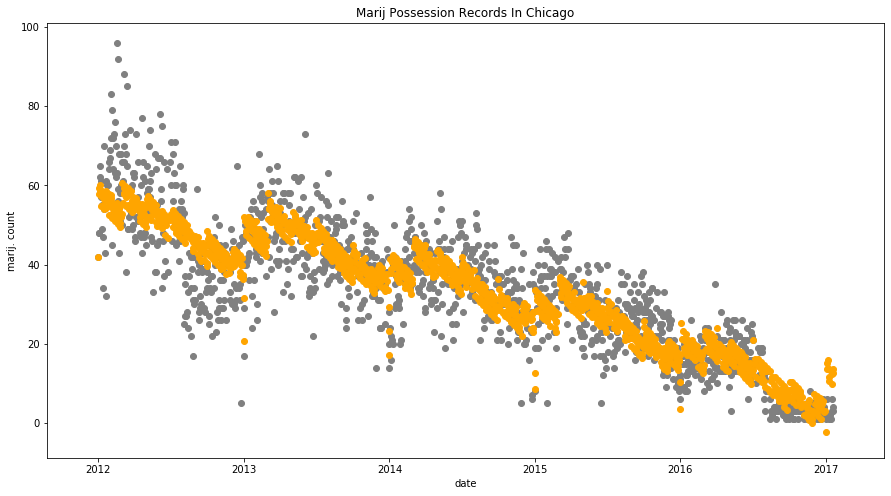

In [0]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x = X_train.index, y = y_train, color = 'gray')
ax.scatter(X_train.index, predictions, color = 'orange')
ax.set(xlabel = 'date', ylabel = 'marij. count', title = 'Marij Possession Records In Chicago')
fig.set_size_inches(15, 8)

### Summary 

In this lesson we saw the different features that we can derive from a single datetime column.  These features include the following:

* `Year`, `Month`, `Week`, `Day`
* `Dayofweek`, `Dayofyear`
* `Is_month_end`, `Is_month_start`, `Is_quarter_end`, `Is_quarter_start`
* `Is_year_end`, `Is_year_start`

To use our datetime data, we first aggregated our records by date to use a day to predict a count of the number of records on that day.  

```python
df_aggregated = df.groupby('date').count()
```

Then we used the `add_datepart` function to derive a list of features from our date.

```python
poss_dates_and_counts = poss_dates_and_counts.assign(date = poss_dates_and_counts.index)

add_datepart(poss_dates_and_counts, 'date')
```

This returned to us a dataframe with a number of new features.  But we wanted to translate our `dayofweek` column into dummy variables to use with linear regression.
```python
days_of_week_df = pd.get_dummies(poss_dates_and_counts.Dayofweek, drop_first=True)
days_of_week_df.columns = ['Sun', 'Mon', 'Tues', 'Weds', 'Thurs', 'Fri']

agg_cats_df = pd.concat([poss_dates_and_counts, days_of_week_df], axis=1)
```

With our features in place, we were then ready to train and fit our model.

### Resources

[StackOverflow DateTime](https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data)